# Building Predictive Models

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

## Import Data

Train and test data were randomly split within R, using 0.80 ratio.
<br>The two dataframes were written to independent csv files, and will be brought into the Python notebook now.

In [2]:
# set path to processed train/test data
processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
train_file_path = os.path.join(processed_data_path, 'train.txt')
test_file_path = os.path.join(processed_data_path, 'test.txt')

In [3]:
df_train = pd.read_csv(train_file_path, index_col='Obs')
df_test = pd.read_csv(test_file_path, index_col='Obs')

In [4]:
print('Train data:')
df_train.info()
print('\n')
print('Test data:')
df_test.info()

Train data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 1 to 97
Data columns (total 9 columns):
Unnamed: 0                    76 non-null int64
Y_HighGradeCancer             76 non-null int64
PSALevel                      76 non-null float64
CancerVol                     76 non-null float64
Weight                        76 non-null float64
Age                           76 non-null float64
BenignProstaticHyperplasia    76 non-null float64
SeminalVesicleInvasion        76 non-null int64
CapsularPenetration           76 non-null float64
dtypes: float64(6), int64(3)
memory usage: 5.9 KB


Test data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 5 to 95
Data columns (total 9 columns):
Unnamed: 0                    21 non-null int64
Y_HighGradeCancer             21 non-null int64
PSALevel                      21 non-null float64
CancerVol                     21 non-null float64
Weight                        21 non-null float64
Age                           2

In [5]:
df_train.columns

Index(['Unnamed: 0', 'Y_HighGradeCancer', 'PSALevel', 'CancerVol', 'Weight',
       'Age', 'BenignProstaticHyperplasia', 'SeminalVesicleInvasion',
       'CapsularPenetration'],
      dtype='object')

It looks like R appended an additional "Unnamed: 0" column, most likely related to indexing.<br>
I will remove that now.

In [6]:
# drop the redudent columns (R auto-created an index column of its own); can be seen in info() cell above
df_train = df_train.drop(columns='Unnamed: 0')
df_test = df_test.drop(columns='Unnamed: 0')

In [7]:
# examine train set
df_train.head()

,Y_HighGradeCancer,PSALevel,CancerVol,Weight,Age,BenignProstaticHyperplasia,SeminalVesicleInvasion,CapsularPenetration
Obs,,,,,,,,
1,0,-2.533700,-1.645747,-1.785921,-1.872101,-0.840562,0,-0.596573
2,0,-2.299250,-1.995368,-0.673281,-0.791989,-0.840562,0,-0.596573
3,0,-2.299250,-1.586043,-1.947772,1.368234,-0.840562,0,-0.596573
4,0,-2.299250,-2.174506,-0.754163,-0.791989,-0.840562,0,-0.596573
6,0,-1.488689,-2.046685,-0.855308,-1.872101,-0.840562,0,-0.596573


In [8]:
# examine test set
df_test.head()

,Y_HighGradeCancer,PSALevel,CancerVol,Weight,Age,BenignProstaticHyperplasia,SeminalVesicleInvasion,CapsularPenetration
Obs,,,,,,,,
5,0,-1.837148,-0.511447,-0.450690,-0.251933,-0.840562,0,-0.596573
8,0,-1.418947,-0.562625,-0.228166,-0.791989,0.706307,0,-0.596573
14,0,-0.983519,0.111131,-1.320605,0.423137,-0.840562,0,-0.596573
17,0,-0.878912,-1.509353,-0.268658,0.828178,0.305380,0,-0.450762
23,0,-0.678455,-1.611706,-0.551853,-0.656975,-0.691566,0,-0.596573


In [9]:
# create a list which captures fields to ommit from model
skip = ['Y_HighGradeCancer'
        , 'Age'
        , 'Weight'
        , 'BenignProstaticHyperplasia'
        , 'SeminalVesicleInvasion'
        , 'CapsularPenetration'
       ]
cols_model = [col for col in df_train.columns if col not in skip]
cols_model

['PSALevel', 'CancerVol']

## Data Preperation

Because R has already prepared the training and test sets, I will manually assign the split data to appropriate variables now.

In [10]:
# train-test split
X_train = df_train.loc[:, cols_model]
y_train = df_train['Y_HighGradeCancer']
X_test = df_test.loc[:, cols_model]
y_test = df_test['Y_HighGradeCancer']

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(76, 2) (76,)
(21, 2) (21,)


In [12]:
# average survival in train and test sets
print(f'Mean y in train set: {round(np.mean(y_train), 3)}')
print(f'Mean y in test set: {round(np.mean(y_test), 3)}')

Mean y in train set: 0.184
Mean y in test set: 0.333


## Baseline Model

Developing a basline model:
- Here, I will feed the dummy model training data, and sklearn will determine the most frequent classification within the Y_HighGradeCancer field (via prior analysis we know this to value to be 0). Because Y_HighGradeCancer = 0 most freqently, the model will be designed to predict 0 on every single observation.
- After the design of the baseline model, I will implement it on both the training and testing data, and calculate accuracy scores and confusion matrixes for good measure.
- Subsequent model fittings can therefore be compared to the baseline model.

In [13]:
# import function
from sklearn.dummy import DummyClassifier

In [14]:
# create model
# because mean y in train = 0.184 (shown above), this "most frequent" model will predict y=0 for all test observations
model_dummy = DummyClassifier(strategy='most_frequent', random_state=0)

In [15]:
# train model
model_dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='most_frequent')

In [16]:
# run dummy_model with training data
print(f'Score for baseline model (TRAINING): {round(model_dummy.score(X_train, y_train), 2)}')

# run dummy_model with testing data
print(f'Score for baseline model (TESTING): {round(model_dummy.score(X_test, y_test), 2)}')

Score for baseline model (TRAINING): 0.82
Score for baseline model (TESTING): 0.67


In [17]:
# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [18]:
# training confusion matrix
print(f'Confusion matrix for baseline model (TRAINING): \n {confusion_matrix(y_train, model_dummy.predict(X_train))} \n')

# testing confusion matrix
print(f'Confusion matrix for baseline model (TESTING): \n {confusion_matrix(y_test, model_dummy.predict(X_test))}')

Confusion matrix for baseline model (TRAINING): 
 [[62  0]
 [14  0]] 

Confusion matrix for baseline model (TESTING): 
 [[14  0]
 [ 7  0]]


## Statsmodels Library

### Full Logistics Model

In [19]:
import statsmodels.api as sm

In [20]:
X_model = sm.add_constant(X_train)
model = sm.Logit(y_train, X_model)

C:\Users\jaosi\Anaconda3\envs\datSci\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.293604
         Iterations 8


In [22]:
### full model statistical output
print(results.summary2(alpha=0.10))

                          Results: Logit
Model:              Logit             Pseudo R-squared: 0.385     
Dependent Variable: Y_HighGradeCancer AIC:              50.6278   
Date:               2020-11-23 02:07  BIC:              57.6200   
No. Observations:   76                Log-Likelihood:   -22.314   
Df Model:           2                 LL-Null:          -36.307   
Df Residuals:       73                LLR p-value:      8.3761e-07
Converged:          1.0000            Scale:            1.0000    
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.05    0.95] 
-------------------------------------------------------------------
const          -2.6867    0.6186  -4.3429  0.0000  -3.7042  -1.6691
PSALevel        1.0577    0.6198   1.7067  0.0879   0.0383   2.0772
CancerVol       1.5502    0.6859   2.2599  0.0238   0.4219   2.6784



In [23]:
PSALevel_list = X_train['PSALevel'].tolist()
CancerVol_list = X_train['CancerVol'].tolist()
Y_HighGradeCancer_list = y_train.tolist()

In [24]:
type(np.arange(1, 2, 0.5))

numpy.ndarray

## Advanced Visualizations Using Matplotlib

In [25]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

### Logistic Regression Plot

Text(0.5, 0.92, 'Prostate Cancer: Logistic Regression')

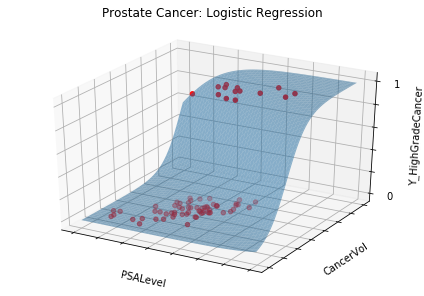

In [26]:
%matplotlib inline

# bring in and store the coefficients of the fitted model
const_coeff, x1_coeff, x2_coeff = results.params

# define a sigmoid function of 2 variables
def sigmoid(x1, x2):
    func = 1.0 / (1.0 + math.exp(-(const_coeff + x1_coeff*x1 + x2_coeff*x2)))
    return func

# design plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.tight_layout()
x = y = np.arange(-3.0, 4.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([sigmoid(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

# draw plots
ax.plot_surface(X, Y, Z, alpha=0.5)
ax.scatter(PSALevel_list, CancerVol_list, Y_HighGradeCancer_list, c='red', marker='o')

# modify axes and labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([0, 0, '', '', '', '', 1])
ax.set_xlabel('PSALevel')
ax.set_ylabel('CancerVol')
ax.set_zlabel('Y_HighGradeCancer')
ax.set_title('Prostate Cancer: Logistic Regression')